In [1]:
import torch
import phate
import scprep
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import os
import sys

In [26]:
#Obtain tree data
#default params nbranch=5, branch_length=100
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=10, branch_length=200)

In [27]:
#Get phate operator
phate_operator = phate.PHATE(random_state=42)
tree_phate = phate_operator.fit_transform(tree_data)

Calculating PHATE...
  Running PHATE on 2000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.09 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 1.09 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.50 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.14 seconds.
Calculated PHATE in 6.84 seconds.


(2000, 10)
(2000, 2)
(2000,)


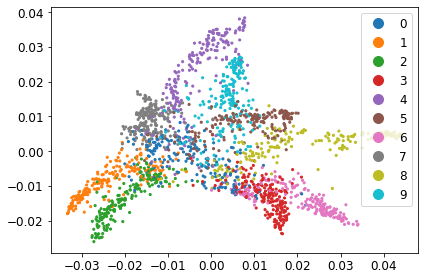

In [28]:
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)
print(tree_data.shape)
print(tree_phate.shape)
print(tree_clusters.shape)

In [29]:
#Data
X = torch.tensor(tree_data, requires_grad=True)
n = tree_data.shape[0]
random_indices = np.random.randint(n, size=n)

In [30]:
%%time


def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")

    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)

    kernel = gaussian_kernel(dists)
    p = kernel / kernel.sum(axis=0)[:, None]
    pt = torch.matrix_power(p, t)
    log_p = torch.log(pt)
    return pt



CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.3 µs


With the Autoencoder

In [31]:
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder_layer=[10, 10, 10],
        decoder_layer=[10, 10, 10],
        activation="ReLU",
        use_cuda=False,
    ) -> None:
        super().__init__()
        device = "cuda" if use_cuda else "cpu"
        encoder = []
        for i0, i1 in zip(encoder_layer, encoder_layer[1:]):
            encoder.append(nn.Linear(i0, i1))
            if i1 == 10:
                encoder.append(getattr(nn, "ReLU")())
            else:
                encoder.append(getattr(nn, "ReLU")())
        print(encoder)
        self.encoder = nn.Sequential(*encoder).to(device)
        decoder=[]
        for i0,i1 in zip(decoder_layer,decoder_layer[1:]):
           decoder.append(nn.Linear(i0, i1))
           decoder.append(getattr(nn, activation)())
        print(decoder)
        self.decoder = nn.Sequential(*decoder).to(device)

    def encode(self,x):
        x = self.encoder()
        return x

    def decode(self,x):
        x = self.decoder(x)
        return x

In [63]:
#Define Model Characteristics
use_cuda = torch.cuda.is_available()
phate_ae = Autoencoder(
    encoder_layer=[10, 10, 2], decoder_layer=[2, 10, 10], use_cuda=use_cuda
)


optimizer = torch.optim.AdamW(phate_ae.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.05)

n_epochs = 500
n_train = int(n*0.8)

#Get random train indices
fullind = np.arange(tree_data.shape[0])
random_indices = np.random.choice(
    fullind, size=n_train, replace=False
)  

#Define batch size
batch_size = 64
n_batches = int(n_train/batch_size)


for epoch in range(n_epochs):
    
    scheduler.step()
    np.random.shuffle(random_indices)
    optimizer.zero_grad()
    X_sample = X[random_indices].float()  # Get 100 samples
    P = torch_phate(X_sample).cuda()  # Get log proability
    noise = (
        (0.05 * torch.randn(X_sample.size())).cuda()
        if use_cuda
        else 0.05 * torch.randn(X_sample.size())
    )  # define noise from Gaussian distribution
    
    
    for i in range(n_batches):
        
        xbatch = X_sample[i*batch_size:(i*batch_size)+batch_size].detach() #get batch for samples
        pbatch = P[i*batch_size:(i*batch_size)+batch_size].cuda().detach() #get batch for phate embedding
        nbatch = noise[i*batch_size:(i*batch_size)+batch_size].detach() #get batch for noise
        
        xbatch.requires_grad = True
        pbatch.requires_grad = True
        nbatch.requires_grad = True
        
        
        
        encode_sample = phate_ae.encoder(
           xbatch.cuda() + nbatch.cuda()
        )  # encode phate into 2 dimensions

        geom_loss = nn.MSELoss()(
            torch.cdist(encode_sample, encode_sample) ** 2, torch.cdist(pbatch, pbatch) ** 2
        )  # Loss between encoded space and diffusion distance


        decode_sample = phate_ae.decode(encode_sample)  # decode embedding
        recon_loss = nn.MSELoss()(decode_sample,xbatch.cuda())  # Loss decoded embedding and original

        loss = recon_loss + geom_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    

    if epoch % 50 == 0:
        print(recon_loss)
        print(geom_loss)
        print("Loss distance :", loss)

        

[Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=2, bias=True), ReLU()]
[Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]
tensor(74.6593, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(27.1022, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(101.7614, device='cuda:0', grad_fn=<AddBackward0>)
tensor(76.3166, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7151, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(77.0316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72.7176, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5257, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(73.2433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(66.3175, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9604, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(67.2779, device='cuda:0', grad_f

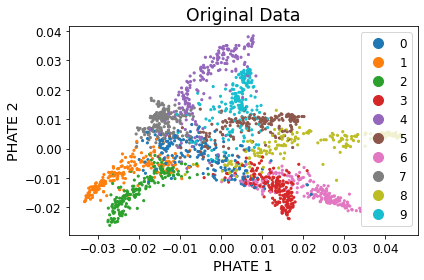

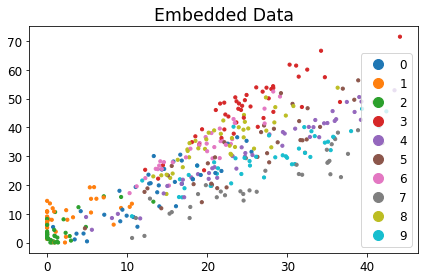

In [56]:
# Get test indices
testind = []
fullind = list(np.arange(tree_data.shape[0]))
for i in fullind:
    if i not in random_indices:
        testind.append(i)

testind = np.array(testind)

# Get samples from autoencoder
nxsample = phate_ae.encoder(X[testind].float().cuda())
xsampout = nxsample.detach().cpu().numpy()

# Visualize ground truth
cax = scprep.plot.scatter2d(
    tree_phate,
    c=tree_clusters,
    title="Original Data",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)


# Visualize Embedding
cax = scprep.plot.scatter2d(xsampout, c=tree_clusters[testind], title="Embedded Data")


# Compute Jacobian
Jacob = []
for i in testind:
    X_sample = X[i].float().cuda()
    J = torch.autograd.functional.jacobian(phate_ae.encoder, X_sample).squeeze()
    Jacob.append(J.cpu().detach().numpy())

AJacob = np.array(Jacob)
prod = np.empty((10,10))

#Compute FIM
FIM = []
for k in range(xsampout.shape[0]):
    prod = np.empty((10,10))
    for i in range(AJacob.shape[2]):
        for j in range(AJacob.shape[2]):
            prod[i,j] = np.mean(AJacob[k,:,i] * AJacob[k,:,j] * np.exp(xsampout[k,:]))

    FIM.append(prod)


    


/tmp/ipykernel_11867/3247693861.py:4: RuntimeWarning: invalid value encountered in sqrt
  V = np.sqrt(np.linalg.det(np.array(FIM)))


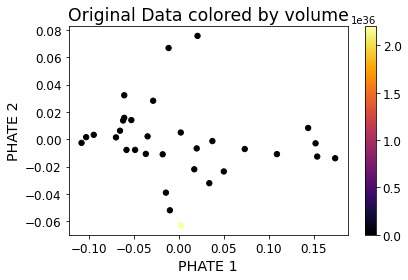

In [82]:
# Analysis/Data Visualization

#Compute Volume
V = np.sqrt(np.linalg.det(np.array(FIM)))

#Visualize Original PHATE data with volume measurement
# Visualize ground truth
cax = scprep.plot.scatter2d(
    tree_phate[testind],
    c=V,
    title="Original Data colored by volume",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)

